# Keras tuner

Keras tuner and hyperparameters search. Maybe some architecture search as well.

Manual: https://www.tensorflow.org/tutorials/keras/keras_tuner

Some coolest thing about **Keras tuner**, compared a naive manual approach:

* It doesn't explore bad solutions if they are clearly losing (uses some sort of a champinshop approach)
* It saves checkpoints, so doesn't do extra work if it can be avoided (starts from the same point where it stopped, if further investigation is required)

Optimal params it found for this example: learning rate of 0.01; network shape of 64→992

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kerastuner as kt

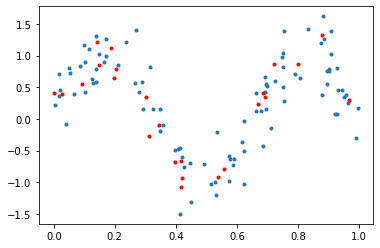

In [2]:
# Cook some simplistic data:
np.random.seed(1)
n_points = 120
x = np.random.uniform(size=n_points)
y = np.sin(x*3*np.pi) + np.random.normal(size=x.shape)/3

ind = list(range(np.round(n_points*0.2).astype(int)))
xtest = x[ind]
ytest = y[ind]
x = x[[i for i in range(n_points) if i not in ind ]]
y = y[[i for i in range(n_points) if i not in ind ]]

plt.plot(x,y,'.');
plt.plot(xtest, ytest, 'r.');

In [3]:
# Custom callback, to see what's happening during the training
# https://www.tensorflow.org/guide/keras/custom_callback

class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            print(f"{logs['loss']:0.3}", end=' ')

In [14]:
def make_model_for_tuning(hp):
    
    n_units1 = hp.Int('n_units1', min_value = 32, max_value = 1024, step = 32)
    n_units2 = hp.Int('n_units2', min_value = 32, max_value = 1024, step = 32)
    # These strings inside are the name for the parameter
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)), # https://www.tensorflow.org/api_docs/python/tf/keras/Input
        tf.keras.layers.Dense(n_units1),   # See how parameters take values from this hp.Int() object,
        tf.keras.layers.LeakyReLU(),       # ... instead of normal numbers, as one woudl expect.
        tf.keras.layers.Dense(n_units2),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    
    # This is the key line: it defines the tuning space
    learning_rate = hp.Choice('learning_rate', values = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
    
    model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=['mean_squared_error'])
    return model

#model = make_model((8,89))
#model.summary()

In [15]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(make_model_for_tuning,
                     objective='val_loss', 
                     max_epochs=10,
                     factor=3,
                     directory = 'C:/Temp/temp_keras_tuner_dir',
                     project_name = 'keras_tuner_intro'
                    )  

Some notes on the init above:

* A local dir for `directory` didn't work for me; I suspect that's because my hirerachy of folders, followed by a longish aut-generated file name, became too long for the system to handle it. Switching to a more "root" directory fixed the issue.
* If the optimizer finished running, you cannot run it again with the same `project_name`, and a new set of parameters in the model declaration. It seems that it tries to read the checkpoints, and fails. Either change the `project_name`, or delete the folder to start anew.

In [16]:
# A technical override that clears notebook outputs, and is recommended by the ktuner tutorial,
# just to make it look neater.
# Not required tho. And doesn't work for me amyways.

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [17]:
# Hyperparameter search

tuner.search(x, y, epochs = 10, 
             validation_data = (xtest, ytest));#, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The optimal number of units in the first densely-connected
layer is {best_hps.get('n_units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.4265 - mean_squared_error: 0.42 - 0s 56ms/step - loss: 1.4495 - mean_squared_error: 1.4495 - val_loss: 0.6462 - val_mean_squared_error: 0.6462
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.6728 - mean_squared_error: 0.67 - 0s 37ms/step - loss: 0.7313 - mean_squared_error: 0.7313 - val_loss: 0.5391 - val_mean_squared_error: 0.5391


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.7077 - mean_squared_error: 0.70 - 0s 49ms/step - loss: 0.5293 - mean_squared_error: 0.5293 - val_loss: 0.5289 - val_mean_squared_error: 0.5289
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.5505 - mean_squared_error: 0.55 - 0s 13ms/step - loss: 0.5238 - mean_squared_error: 0.5238 - val_loss: 0.5383 - val_mean_squared_error: 0.5383


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.4841 - mean_squared_error: 0.48 - 0s 50ms/step - loss: 0.8114 - mean_squared_error: 0.8114 - val_loss: 0.5345 - val_mean_squared_error: 0.5345
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.4316 - mean_squared_error: 0.43 - 0s 12ms/step - loss: 0.6556 - mean_squared_error: 0.6556 - val_loss: 0.5441 - val_mean_squared_error: 0.5441


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6599 - mean_squared_error: 0.65 - 0s 50ms/step - loss: 1.9599 - mean_squared_error: 1.9599 - val_loss: 0.6817 - val_mean_squared_error: 0.6817
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.8168 - mean_squared_error: 0.81 - 0s 13ms/step - loss: 0.6797 - mean_squared_error: 0.6797 - val_loss: 0.8877 - val_mean_squared_error: 0.8877


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6934 - mean_squared_error: 0.69 - 0s 55ms/step - loss: 3.3558 - mean_squared_error: 3.3558 - val_loss: 1.0475 - val_mean_squared_error: 1.0475
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 1.3250 - mean_squared_error: 1.32 - 0s 13ms/step - loss: 0.9514 - mean_squared_error: 0.9514 - val_loss: 1.1383 - val_mean_squared_error: 1.1383


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.4589 - mean_squared_error: 0.45 - 0s 55ms/step - loss: 99.4128 - mean_squared_error: 99.4128 - val_loss: 16.7643 - val_mean_squared_error: 16.7643
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 18.5533 - mean_squared_error: 18.55 - 0s 30ms/step - loss: 8.7699 - mean_squared_error: 8.7699 - val_loss: 6.9273 - val_mean_squared_error: 6.9273


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6050 - mean_squared_error: 0.60 - 0s 48ms/step - loss: 62.1649 - mean_squared_error: 62.1649 - val_loss: 6.4181 - val_mean_squared_error: 6.4181
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 6.9911 - mean_squared_error: 6.99 - 0s 26ms/step - loss: 2.8842 - mean_squared_error: 2.8842 - val_loss: 0.8925 - val_mean_squared_error: 0.8925


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.5311 - mean_squared_error: 0.53 - 0s 49ms/step - loss: 3256.8943 - mean_squared_error: 3256.8943 - val_loss: 484.4633 - val_mean_squared_error: 484.4633
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 480.3474 - mean_squared_error: 480.34 - 0s 29ms/step - loss: 260.4234 - mean_squared_error: 260.4234 - val_loss: 15.3741 - val_mean_squared_error: 15.3741


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.5939 - mean_squared_error: 0.59 - 0s 52ms/step - loss: 5.4684 - mean_squared_error: 5.4684 - val_loss: 1.3580 - val_mean_squared_error: 1.3580
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 2.1534 - mean_squared_error: 2.15 - 0s 30ms/step - loss: 1.4793 - mean_squared_error: 1.4793 - val_loss: 0.8174 - val_mean_squared_error: 0.8174


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.4907 - mean_squared_error: 0.49 - 0s 49ms/step - loss: 0.5512 - mean_squared_error: 0.5512 - val_loss: 0.5682 - val_mean_squared_error: 0.5682
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.3922 - mean_squared_error: 0.39 - 0s 27ms/step - loss: 0.5274 - mean_squared_error: 0.5274 - val_loss: 0.5089 - val_mean_squared_error: 0.5089


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6435 - mean_squared_error: 0.64 - 0s 50ms/step - loss: 0.7796 - mean_squared_error: 0.7796 - val_loss: 0.5469 - val_mean_squared_error: 0.5469
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.4427 - mean_squared_error: 0.44 - 0s 29ms/step - loss: 0.5981 - mean_squared_error: 0.5981 - val_loss: 0.4983 - val_mean_squared_error: 0.4983


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6595 - mean_squared_error: 0.65 - 0s 53ms/step - loss: 167.2195 - mean_squared_error: 167.2195 - val_loss: 107.2563 - val_mean_squared_error: 107.2563
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 102.9926 - mean_squared_error: 102.99 - 0s 13ms/step - loss: 55.3403 - mean_squared_error: 55.3403 - val_loss: 132.2670 - val_mean_squared_error: 132.2670


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.6568 - mean_squared_error: 0.65 - 0s 49ms/step - loss: 0.7849 - mean_squared_error: 0.7849 - val_loss: 0.5398 - val_mean_squared_error: 0.5398
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.5808 - mean_squared_error: 0.58 - 0s 30ms/step - loss: 0.5909 - mean_squared_error: 0.5909 - val_loss: 0.4960 - val_mean_squared_error: 0.4960


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.8122 - mean_squared_error: 0.81 - 0s 51ms/step - loss: 0.6164 - mean_squared_error: 0.6164 - val_loss: 0.5554 - val_mean_squared_error: 0.5554
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.5209 - mean_squared_error: 0.52 - 0s 28ms/step - loss: 0.5304 - mean_squared_error: 0.5304 - val_loss: 0.5301 - val_mean_squared_error: 0.5301


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.7051 - mean_squared_error: 0.70 - 0s 51ms/step - loss: 0.5527 - mean_squared_error: 0.5527 - val_loss: 0.5263 - val_mean_squared_error: 0.5263
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4118 - mean_squared_error: 0.41 - 0s 13ms/step - loss: 0.5237 - mean_squared_error: 0.5237 - val_loss: 0.5267 - val_mean_squared_error: 0.5267


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.6849 - mean_squared_error: 0.68 - 0s 50ms/step - loss: 0.8431 - mean_squared_error: 0.8431 - val_loss: 0.5463 - val_mean_squared_error: 0.5463
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4517 - mean_squared_error: 0.45 - 0s 29ms/step - loss: 0.5883 - mean_squared_error: 0.5883 - val_loss: 0.5124 - val_mean_squared_error: 0.5124


Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.4559 - mean_squared_error: 0.45 - 0s 52ms/step - loss: 0.6992 - mean_squared_error: 0.6992 - val_loss: 0.5474 - val_mean_squared_error: 0.5474
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.6103 - mean_squared_error: 0.61 - 0s 31ms/step - loss: 0.5693 - mean_squared_error: 0.5693 - val_loss: 0.4870 - val_mean_squared_error: 0.4870
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.5824 - mean_squared_error: 0.58 - 0s 14ms/step - loss: 0.4841 - mean_squared_error: 0.4841 - val_loss: 0.5796 - val_mean_squared_error: 0.5796
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.5562 - mean_squared_error: 0.55 - 0s 29ms/step - loss: 0.4912 - mean_squared_error: 0.4912 - val_loss: 0.4807 - val_mean_squared_error: 0.4807
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.5101 - mean_squared_error: 0.51 - 0s 34ms/step - loss: 0.4671 - mean_squared_error: 0.46

Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.6761 - mean_squared_error: 0.67 - 0s 51ms/step - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.5331 - val_mean_squared_error: 0.5331
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.5181 - mean_squared_error: 0.51 - 0s 31ms/step - loss: 0.5514 - mean_squared_error: 0.5514 - val_loss: 0.5172 - val_mean_squared_error: 0.5172
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.5246 - mean_squared_error: 0.52 - 0s 13ms/step - loss: 0.5151 - mean_squared_error: 0.5151 - val_loss: 0.5337 - val_mean_squared_error: 0.5337
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.5488 - mean_squared_error: 0.54 - 0s 13ms/step - loss: 0.4982 - mean_squared_error: 0.4982 - val_loss: 0.5230 - val_mean_squared_error: 0.5230
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.6025 - mean_squared_error: 0.60 - 0s 28ms/step - loss: 0.4662 - mean_squared_error: 0.46

Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.5333 - mean_squared_error: 0.53 - 0s 57ms/step - loss: 11167.6133 - mean_squared_error: 11167.6133 - val_loss: 1984.4648 - val_mean_squared_error: 1984.4648
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 2254.3691 - mean_squared_error: 2254.36 - 0s 12ms/step - loss: 824.3918 - mean_squared_error: 824.3918 - val_loss: 6909.6001 - val_mean_squared_error: 6909.6001
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 7944.5815 - mean_squared_error: 7944.58 - 0s 13ms/step - loss: 3983.3486 - mean_squared_error: 3983.3486 - val_loss: 4954.0210 - val_mean_squared_error: 4954.0210
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 5937.3364 - mean_squared_error: 5937.33 - 0s 34ms/step - loss: 3718.5969 - mean_squared_error: 3718.5969 - val_loss: 344.0922 - val_mean_squared_error: 344.0922


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.5504 - mean_squared_error: 0.55 - 0s 51ms/step - loss: 8.3418 - mean_squared_error: 8.3418 - val_loss: 1.5371 - val_mean_squared_error: 1.5371
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 1.7922 - mean_squared_error: 1.79 - 0s 29ms/step - loss: 1.3227 - mean_squared_error: 1.3227 - val_loss: 1.1315 - val_mean_squared_error: 1.1315
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.8153 - mean_squared_error: 0.81 - 0s 13ms/step - loss: 1.1392 - mean_squared_error: 1.1392 - val_loss: 1.6028 - val_mean_squared_error: 1.6028
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 2.0556 - mean_squared_error: 2.05 - 0s 30ms/step - loss: 1.1150 - mean_squared_error: 1.1150 - val_loss: 1.1090 - val_mean_squared_error: 1.1090


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.5113 - mean_squared_error: 0.51 - 0s 50ms/step - loss: 0.5572 - mean_squared_error: 0.5572 - val_loss: 0.5610 - val_mean_squared_error: 0.5610
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.7371 - mean_squared_error: 0.73 - 0s 27ms/step - loss: 0.5464 - mean_squared_error: 0.5464 - val_loss: 0.5242 - val_mean_squared_error: 0.5242
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.6296 - mean_squared_error: 0.62 - 0s 25ms/step - loss: 0.5388 - mean_squared_error: 0.5388 - val_loss: 0.5031 - val_mean_squared_error: 0.5031
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4515 - mean_squared_error: 0.45 - 0s 13ms/step - loss: 0.4956 - mean_squared_error: 0.4956 - val_loss: 0.5210 - val_mean_squared_error: 0.5210


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.5731 - mean_squared_error: 0.57 - 0s 50ms/step - loss: 0.5485 - mean_squared_error: 0.5485 - val_loss: 0.5289 - val_mean_squared_error: 0.5289
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.3621 - mean_squared_error: 0.36 - 0s 12ms/step - loss: 0.5251 - mean_squared_error: 0.5251 - val_loss: 0.5465 - val_mean_squared_error: 0.5465
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.5169 - mean_squared_error: 0.51 - 0s 26ms/step - loss: 0.5205 - mean_squared_error: 0.5205 - val_loss: 0.5205 - val_mean_squared_error: 0.5205
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4985 - mean_squared_error: 0.49 - 0s 26ms/step - loss: 0.5036 - mean_squared_error: 0.5036 - val_loss: 0.5079 - val_mean_squared_error: 0.5079


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.8094 - mean_squared_error: 0.80 - 0s 50ms/step - loss: 0.5263 - mean_squared_error: 0.5263 - val_loss: 0.5954 - val_mean_squared_error: 0.5954
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.4170 - mean_squared_error: 0.41 - 0s 26ms/step - loss: 0.5509 - mean_squared_error: 0.5509 - val_loss: 0.5208 - val_mean_squared_error: 0.5208
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.4145 - mean_squared_error: 0.41 - 0s 27ms/step - loss: 0.5052 - mean_squared_error: 0.5052 - val_loss: 0.5115 - val_mean_squared_error: 0.5115
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4072 - mean_squared_error: 0.40 - 0s 28ms/step - loss: 0.5224 - mean_squared_error: 0.5224 - val_loss: 0.5026 - val_mean_squared_error: 0.5026


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.5651 - mean_squared_error: 0.56 - 0s 52ms/step - loss: 1.1601 - mean_squared_error: 1.1601 - val_loss: 0.5561 - val_mean_squared_error: 0.5561
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.6721 - mean_squared_error: 0.67 - 0s 28ms/step - loss: 0.6057 - mean_squared_error: 0.6057 - val_loss: 0.5002 - val_mean_squared_error: 0.5002
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.4603 - mean_squared_error: 0.46 - 0s 12ms/step - loss: 0.5709 - mean_squared_error: 0.5709 - val_loss: 0.6371 - val_mean_squared_error: 0.6371
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4578 - mean_squared_error: 0.45 - 0s 27ms/step - loss: 0.5033 - mean_squared_error: 0.5033 - val_loss: 0.4787 - val_mean_squared_error: 0.4787


Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.6148 - mean_squared_error: 0.61 - 0s 51ms/step - loss: 0.7912 - mean_squared_error: 0.7912 - val_loss: 0.6275 - val_mean_squared_error: 0.6275
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.8730 - mean_squared_error: 0.87 - 0s 26ms/step - loss: 0.6366 - mean_squared_error: 0.6366 - val_loss: 0.5080 - val_mean_squared_error: 0.5080
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.5741 - mean_squared_error: 0.57 - 0s 12ms/step - loss: 0.4978 - mean_squared_error: 0.4978 - val_loss: 0.5445 - val_mean_squared_error: 0.5445
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.4329 - mean_squared_error: 0.43 - 0s 27ms/step - loss: 0.4824 - mean_squared_error: 0.4824 - val_loss: 0.4719 - val_mean_squared_error: 0.4719
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.2475 - mean_squared_error: 0.24 - 0s 28ms/step - loss: 0.4767 - mean_squared_error: 0.47

Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.4854 - mean_squared_error: 0.48 - 0s 51ms/step - loss: 0.5204 - mean_squared_error: 0.5204 - val_loss: 0.5586 - val_mean_squared_error: 0.5586
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.5831 - mean_squared_error: 0.58 - 0s 27ms/step - loss: 0.5328 - mean_squared_error: 0.5328 - val_loss: 0.5284 - val_mean_squared_error: 0.5284
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.5658 - mean_squared_error: 0.56 - 0s 29ms/step - loss: 0.5076 - mean_squared_error: 0.5076 - val_loss: 0.5072 - val_mean_squared_error: 0.5072
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.6291 - mean_squared_error: 0.62 - 0s 30ms/step - loss: 0.5009 - mean_squared_error: 0.5009 - val_loss: 0.4973 - val_mean_squared_error: 0.4973
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.5101 - mean_squared_error: 0.51 - 0s 28ms/step - loss: 0.4944 - mean_squared_error: 0.49

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.5841 - mean_squared_error: 0.58 - 0s 48ms/step - loss: 0.9578 - mean_squared_error: 0.9578 - val_loss: 0.5672 - val_mean_squared_error: 0.5672
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.5851 - mean_squared_error: 0.58 - 0s 29ms/step - loss: 0.7062 - mean_squared_error: 0.7062 - val_loss: 0.5590 - val_mean_squared_error: 0.5590
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.6797 - mean_squared_error: 0.67 - 0s 29ms/step - loss: 0.5352 - mean_squared_error: 0.5352 - val_loss: 0.5244 - val_mean_squared_error: 0.5244
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.5710 - mean_squared_error: 0.57 - 0s 13ms/step - loss: 0.5146 - mean_squared_error: 0.5146 - val_loss: 0.5593 - val_mean_squared_error: 0.5593
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.5933 - mean_squared_error: 0.59 - 0s 26ms/step - loss: 0.5213 - mean_squared_error: 0.52

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.5395 - mean_squared_error: 0.53 - 0s 160ms/step - loss: 0.6124 - mean_squared_error: 0.6124 - val_loss: 0.5264 - val_mean_squared_error: 0.5264
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.5774 - mean_squared_error: 0.57 - 0s 36ms/step - loss: 0.5225 - mean_squared_error: 0.5225 - val_loss: 0.5151 - val_mean_squared_error: 0.5151
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.5868 - mean_squared_error: 0.58 - 0s 36ms/step - loss: 0.5069 - mean_squared_error: 0.5069 - val_loss: 0.5123 - val_mean_squared_error: 0.5123
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.4601 - mean_squared_error: 0.46 - 0s 13ms/step - loss: 0.5029 - mean_squared_error: 0.5029 - val_loss: 0.5156 - val_mean_squared_error: 0.5156
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.5037 - mean_squared_error: 0.50 - 0s 35ms/step - loss: 0.4881 - mean_squared_error: 0.4

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.6652 - mean_squared_error: 0.66 - 0s 55ms/step - loss: 0.5556 - mean_squared_error: 0.5556 - val_loss: 0.5707 - val_mean_squared_error: 0.5707
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.3877 - mean_squared_error: 0.38 - 0s 33ms/step - loss: 0.5281 - mean_squared_error: 0.5281 - val_loss: 0.5185 - val_mean_squared_error: 0.5185
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.5998 - mean_squared_error: 0.59 - 0s 34ms/step - loss: 0.5090 - mean_squared_error: 0.5090 - val_loss: 0.5120 - val_mean_squared_error: 0.5120
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.3780 - mean_squared_error: 0.37 - 0s 32ms/step - loss: 0.5139 - mean_squared_error: 0.5139 - val_loss: 0.5026 - val_mean_squared_error: 0.5026
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.4028 - mean_squared_error: 0.40 - 0s 12ms/step - loss: 0.4948 - mean_squared_error: 0.49

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.5495 - mean_squared_error: 0.54 - 0s 48ms/step - loss: 0.5773 - mean_squared_error: 0.5773 - val_loss: 0.5798 - val_mean_squared_error: 0.5798
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.6530 - mean_squared_error: 0.65 - 0s 26ms/step - loss: 0.5372 - mean_squared_error: 0.5372 - val_loss: 0.5194 - val_mean_squared_error: 0.5194
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.6113 - mean_squared_error: 0.61 - 0s 28ms/step - loss: 0.5160 - mean_squared_error: 0.5160 - val_loss: 0.5144 - val_mean_squared_error: 0.5144
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.3747 - mean_squared_error: 0.37 - 0s 29ms/step - loss: 0.5138 - mean_squared_error: 0.5138 - val_loss: 0.5047 - val_mean_squared_error: 0.5047
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.5039 - mean_squared_error: 0.50 - 0s 13ms/step - loss: 0.4904 - mean_squared_error: 0.49

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.01.



In [18]:
best_hps.values

{'n_units1': 64,
 'n_units2': 992,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}